In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from green_mood_tracker.training_data import get_raw_data_notebook
from green_mood_tracker.data_cleaning import clean

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cleme\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## download and clean data

In [2]:
%%time
raw_data = get_raw_data_notebook(True)
raw_data.head()

c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\training_data.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sentiment140_final['source'] = 'sentiment140'
c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\training_data.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  complete_data_binary['polarity'] = complete_data_binary.polarity.map({4:1,0:0})


Wall time: 56.1 s


,id,text,polarity,source
0,1467933112,the angel is going to miss the athlete this we...,0,sts_gold
1,2323395086,It looks as though Shaq is getting traded to C...,0,sts_gold
2,1467968979,@clarianne APRIL 9TH ISN'T COMING SOON ENOUGH,0,sts_gold
3,1990283756,drinking a McDonalds coffee and not understand...,0,sts_gold
4,1988884918,So dissapointed Taylor Swift doesnt have a Twi...,0,sts_gold


In [3]:
raw_data.shape

(1620501, 4)

## Explore data

In [4]:
raw_data.source.value_counts()

sentiment140              1600000
kaggle_sentiment_train      16363
kaggle_sentiment_test        2104
sts_gold                     2034
Name: source, dtype: int64

In [5]:
raw_data.polarity.value_counts()

1    810317
0    810184
Name: polarity, dtype: int64

## sample data

In [6]:
data_sample = raw_data.sample(n=25_000,random_state=0).reset_index()

In [7]:
%%time
data_sample_clean = clean(data_sample,'text')
data_sample_clean.head()

Wall time: 58.5 s


,index,id,text,polarity,source
0,336834,2014083611,pinch even fought amma hate new goatee sd look...,0,sentiment140
1,622734,2229303528,didnt even get try week,0,sentiment140
2,1016867,1881768019,giving jack quick hair cut,1,sentiment140
3,1090541,1969804803,pirate game sat sun work monday tuesthur work ...,1,sentiment140
4,947493,1823084268,fun night,1,sentiment140


## split data Train/Test

In [18]:
from sklearn.model_selection import train_test_split

X = data_sample_clean.text
y = data_sample_clean.polarity

In [19]:
sentence_train, sentence_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [22]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

## word2vec

In [30]:
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=sentence_train)
vocab_size=len(word2vec.wv.vocab.keys())

In [31]:
def embed_sentence(word2vec, sentence):
    embedded=[]
    embedded_sentence = []
    for word in sentence:
         if word in word2vec.wv.vocab.keys():
             vector = word2vec.wv[word]
             embedded_sentence.append(vector)                 
    return np.array(embedded_sentence)
        

In [32]:
def embedding(word2vec, sentences):
    embedding=[]
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)  
        embedding.append(embedded_sentence)
    return embedding

In [33]:
def embedding_pipeline(word2vec, X):
    # Step #3: Sentences to list of words
    X = embedding(word2vec, X) 
    # Step #4: Pad the inputs
    X = pad_sequences(X, dtype='float32', padding='post') 
    return X

In [38]:
X_train_pad_w2v = embedding_pipeline(word2vec, sentence_train.values)
X_test_pad_w2v = embedding_pipeline(word2vec, sentence_test.values)

In [39]:
def init_model_w2v(vocab_size):

    model = Sequential()

    model.add(layers.Masking(mask_value=0.))
    model.add(layers.GRU(units=13, activation='tanh')) 
    model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dropout(.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss= 'binary_crossentropy',  
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

### Train word2vec on internal data

In [40]:
%%time
model_w2v = init_model_w2v(vocab_size)

es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
history_w2v = model_w2v.fit(X_train_pad_w2v, y_train,
          validation_split= 2/7,
          epochs=50, 
          batch_size=16, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/50
782/782 [==============================] - 61s 79ms/step - loss: 0.6926 - accuracy: 0.5172 - val_loss: 0.6903 - val_accuracy: 0.5316
Epoch 2/50
782/782 [==============================] - 58s 74ms/step - loss: 0.6897 - accuracy: 0.5316 - val_loss: 0.6885 - val_accuracy: 0.5422
Epoch 3/50
782/782 [==============================] - 57s 72ms/step - loss: 0.6855 - accuracy: 0.5474 - val_loss: 0.6985 - val_accuracy: 0.5282
Epoch 4/50
782/782 [==============================] - 57s 73ms/step - loss: 0.6809 - accuracy: 0.5560 - val_loss: 0.6833 - val_accuracy: 0.5426
Epoch 5/50
782/782 [==============================] - 56s 72ms/step - loss: 0.6769 - accuracy: 0.5674 - val_loss: 0.6838 - val_accuracy: 0.5448
Epoch 6/50
782/782 [==============================] - 58s 75ms/step - loss: 0.6709 - accuracy: 0.5810 - val_loss: 0.6784 - val_accuracy: 0.5592
Epoch 7/50
782/782 [==============================] - 57s 73ms/step - loss: 0.6642 - accuracy: 0.5962 - val_loss: 0.6701 - val_accuracy:

235/235 [==============================] - 3s 14ms/step - loss: 0.6072 - accuracy: 0.6703
accuracy 0.6702666878700256


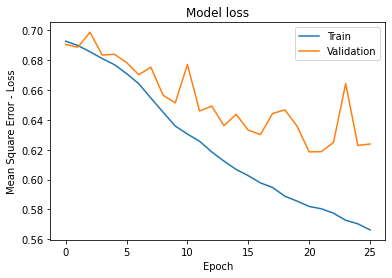

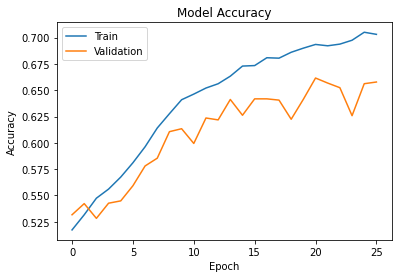

In [42]:
print('accuracy', model_w2v.evaluate(X_test_pad_w2v,y_test)[1])
plot_loss(history_w2v)

### Train word2vec on Google news

In [59]:
%%time
import gensim.downloader as api

Wall time: 0 ns


In [60]:
word2vec_gnews = api.load("glove-twitter-100")
# word2vec_gnews = api.load("word2vec-google-news-300") 300 embedding, probably very long to train, need to init another model, not sure where to input the 300 though

In [61]:
X_train_pad_w2v_gnews = embedding_pipeline(word2vec_gnews, sentence_train[:10000].values)
X_test_pad_w2v_gnews = embedding_pipeline(word2vec_gnews, sentence_test[:10000].values)

c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
c:\users\cleme\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [62]:
X_train_pad_w2v.shape

(17500, 173, 100)

In [63]:
%%time
model_w2v_gnews = init_model_w2v(vocab_size)

es = EarlyStopping(patience=10,restore_best_weights=True,monitor='val_accuracy')
history_w2v_gnews = model_w2v.fit(X_train_pad_w2v_gnews, y_train,
          validation_split= 2/7,
          epochs=50, 
          batch_size=16, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/50
447/447 [==============================] - 35s 78ms/step - loss: 0.5695 - accuracy: 0.6962 - val_loss: 0.6766 - val_accuracy: 0.6361
Epoch 2/50
447/447 [==============================] - 33s 75ms/step - loss: 0.5644 - accuracy: 0.6999 - val_loss: 0.6930 - val_accuracy: 0.6197
Epoch 3/50
447/447 [==============================] - 28s 64ms/step - loss: 0.5604 - accuracy: 0.7027 - val_loss: 0.6725 - val_accuracy: 0.6340
Epoch 4/50
447/447 [==============================] - 37s 82ms/step - loss: 0.5553 - accuracy: 0.7081 - val_loss: 0.7118 - val_accuracy: 0.6200
Epoch 5/50
447/447 [==============================] - 40s 90ms/step - loss: 0.5552 - accuracy: 0.7089 - val_loss: 0.6814 - val_accuracy: 0.6368
Epoch 6/50
447/447 [==============================] - 35s 78ms/step - loss: 0.5484 - accuracy: 0.7118 - val_loss: 0.6875 - val_accuracy: 0.6319
Epoch 7/50
447/447 [==============================] - 39s 88ms/step - loss: 0.5479 - accuracy: 0.7139 - val_loss: 0.6920 - val_accuracy:

235/235 [==============================] - 9s 36ms/step - loss: 0.6949 - accuracy: 0.4925 0s - loss: 0.6949 - accuracy: 
accuracy 0.4925333261489868


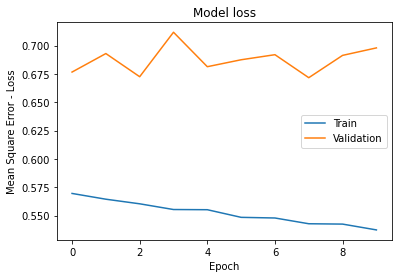

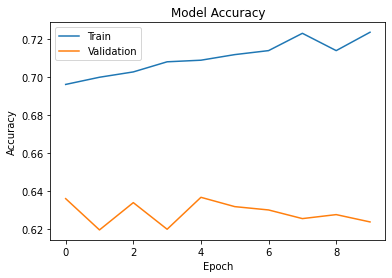

In [69]:
print('accuracy', model_w2v_gnews.evaluate(X_test_pad_w2v_gnews,y_test)[1])
plot_loss(history_w2v_gnews)

In [ ]:
# job save --- not working
# import joblib

# filename = 'model_emb_binary.joblib'
# joblib.dump(model_emb, filename)

# import pickle

# filename = 'model_emb_binary.sav'
# pickle.dump(model_emb, open(filename, 'wb'))

## Evaluate

In [64]:
print('w2v_internal accuracy:',model_w2v.evaluate(X_test_pad_w2v,y_test))

235/235 [==============================] - 5s 21ms/step - loss: 1.0352 - accuracy: 0.5673 0s - loss: 1.037
w2v_internal accuracy: [1.0352450609207153, 0.5673333406448364]


In [68]:
print('w2v_gnews accuracy:',model_w2v.evaluate(X_test_pad_w2v_gnews,y_test))

235/235 [==============================] - 4s 17ms/step - loss: 0.6660 - accuracy: 0.6381
w2v_gnews accuracy: [0.6659895181655884, 0.6381333470344543]


### Predict on London

In [73]:
import nest_asyncio
import sys
from green_mood_tracker.twint_class import TWINT
nest_asyncio.apply()

In [75]:
import sys
sys.path.insert(0, '../green_mood_tracker/')

In [ ]:
kwargs = dict(
    keywords=['nuclear'],
    cities=['London'],
    since = '2020-11-10 12:00:00',
    limit=200,
    file_path='../green_mood_tracker/data/london_nuclear.csv'
)

t = TWINT(**kwargs)

df_city = t.city_csv()

In [ ]:
! ls ../green_mood_tracker/data/

In [ ]:
csv = pd.read_csv('../green_mood_tracker/data/london_nuclear.csv')